## Preprocessing Copy Number

In [2]:
PATH_FOLDER_COPY_NUMBER = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/CopyNumber"
PATH_CASE_ID_STRUCTURE = "./case_id_and_structure.json"

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import torch
import json
import os
import seaborn as sns

with open(PATH_CASE_ID_STRUCTURE, 'r') as file:
    file_parsed = json.load(file)

copy_number_folder_list = []
os_list = []
for key in file_parsed.keys():
    copy_number_folder_list.append(file_parsed[key]["files"]["copy_number"])
    os_list.append(file_parsed[key]['os'])
        

In [4]:
number_of_rows = []
list_df_CNV = []
for root, dirs, files in os.walk(PATH_FOLDER_COPY_NUMBER):
    for dir in dirs:
        for root, dirs, files in os.walk(PATH_FOLDER_COPY_NUMBER + "/" + dir):
            for file in files:
                if file in copy_number_folder_list:
                    list_df_CNV.append(pd.read_csv(PATH_FOLDER_COPY_NUMBER + "/" + dir + "/" + file, sep='\t'))


### Get relevant Gene List and Filter

In [5]:
gene_id_list = []
with open('gene_id_protein_coding.json') as json_file:
   gene_id_list = json.load(json_file)
print(len(gene_id_list))

20092


In [6]:
# Converti gene_id_list in un set per velocizzare le operazioni di lookup
gene_id_set = set(gene_id_list)

# Itera su ogni dataframe nella lista e verifica se i valori di 'gene_id' sono nel set
list_df_CNV_filtered = []

for df in list_df_CNV:
    # Filtra le righe del dataframe dove 'gene_id' è presente in gene_id_set
    df_filtered = df[df['gene_id'].isin(gene_id_set)]
    list_df_CNV_filtered.append(df_filtered)

print(len(list_df_CNV_filtered))


226


In [7]:
df_rows = []
for df in list_df_CNV_filtered:
    df_rows.append(len(df))
print(set(df_rows))

{14155}


{1025, 1028, 1158, 1032, 8, 10, 11, 12, 1033, 9, 1035, 1037, 13, 15, 1168, 1040, 1149, 1045, 14, 1044, 1049, 1055, 33, 34, 35, 36, 1060, 37, 930, 38, 1057, 939, 1072, 945, 1074, 1202, 1076, 1075, 948, 1079, 944, 1084, 957, 1087, 959, 962, 1097, 970, 969, 974, 976, 977, 978, 1107, 986, 1115, 1116, 990, 1118, 992, 1122, 996, 998, 999, 1002, 1135, 1010, 1011, 1013, 1016, 1021, 1150}


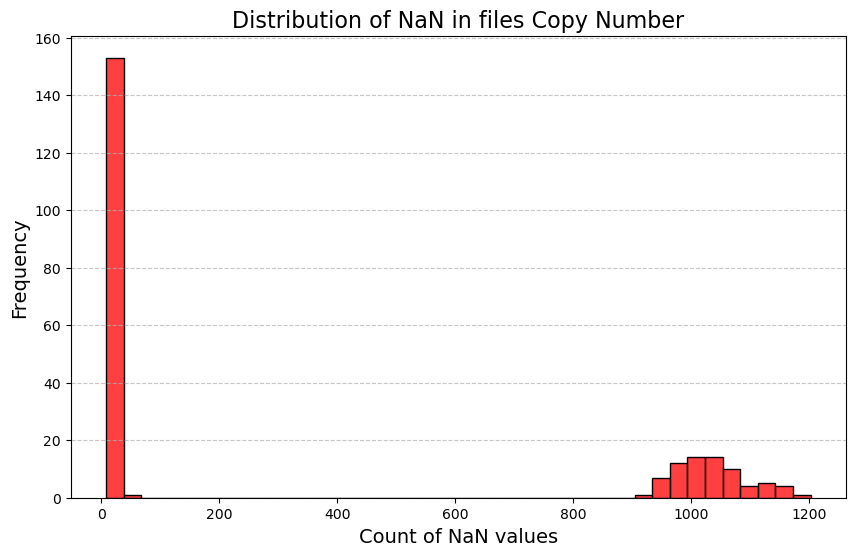

In [8]:
list_NaN = []
for i in range(len(list_df_CNV_filtered)):
    list_NaN.append(list_df_CNV_filtered[i]['copy_number'].isnull().sum())
print(set(list_NaN))

plt.figure(figsize=(10, 6))
sns.histplot(list_NaN, bins=40, kde=False, color="red")
plt.title("Distribution of NaN in files Copy Number", fontsize=16)
plt.xlabel("Count of NaN values", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
list_df_CNV_filtered[0].head()

,gene_id,gene_name,chromosome,start,end,copy_number,min_copy_number,max_copy_number
62,ENSG00000188976.11,NOC2L,chr1,944203,959309,1.0,1.0,1.0
64,ENSG00000187583.11,PLEKHN1,chr1,966482,975865,1.0,1.0,1.0
67,ENSG00000188290.11,HES4,chr1,998962,1000172,1.0,1.0,1.0
68,ENSG00000187608.10,ISG15,chr1,1001138,1014540,1.0,1.0,1.0
75,ENSG00000237330.3,RNF223,chr1,1070967,1074306,1.0,1.0,1.0


In some occasions, one gene may overlap with more than one segment. In this case, min_copy_number is the minimum value of all segments it overlaps, max_copy_number is the maximum value of all segments it overlaps, and copy_number is calculated as the weighted (on length of overlapped regions) median of copy number values from all overlapped segments. When there is a tie (very rare), the smaller number is used. If a gene overlaps with only one segment, copy_number = min_copy_number = max_copy_number. If a gene overlaps with no segments, the gene gets empty value "" in copy_number, min_copy_number and max_copy_number. [GDC documentation](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/CNV_Pipeline/)

### The missing values are going to be filled with 0 value

In [10]:
list_df_CNV_filled = []
for i in range(len(list_df_CNV_filtered)):
    list_df_CNV_filled.append(list_df_CNV_filtered[i].fillna(0))

In [11]:
list_df_CNV_filled[0].head()

,gene_id,gene_name,chromosome,start,end,copy_number,min_copy_number,max_copy_number
62,ENSG00000188976.11,NOC2L,chr1,944203,959309,1.0,1.0,1.0
64,ENSG00000187583.11,PLEKHN1,chr1,966482,975865,1.0,1.0,1.0
67,ENSG00000188290.11,HES4,chr1,998962,1000172,1.0,1.0,1.0
68,ENSG00000187608.10,ISG15,chr1,1001138,1014540,1.0,1.0,1.0
75,ENSG00000237330.3,RNF223,chr1,1070967,1074306,1.0,1.0,1.0


In [12]:
print(list_df_CNV_filled[0].isna().sum())  # Verifica che non ci siano più valori NaN

gene_id            0
gene_name          0
chromosome         0
start              0
end                0
copy_number        0
min_copy_number    0
max_copy_number    0
dtype: int64


Numero di nodi: 2000
Numero di archi: 308


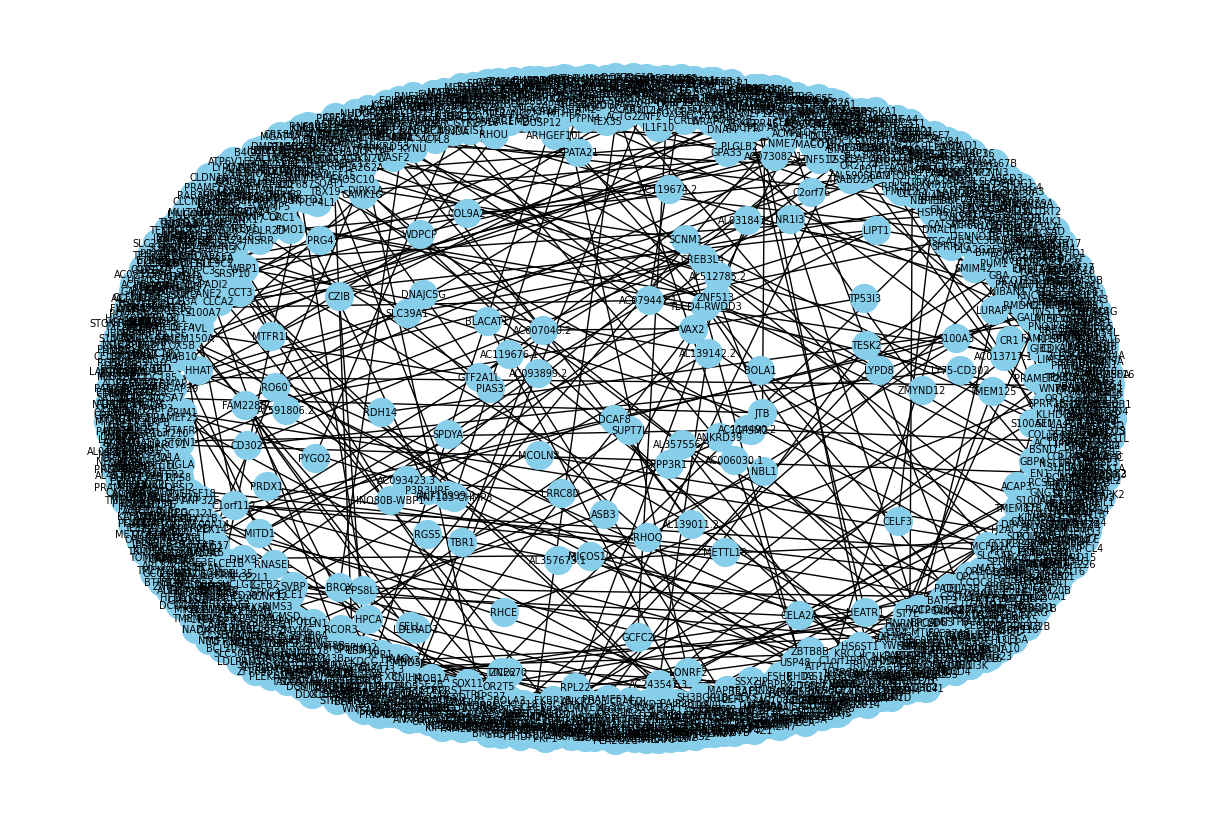

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

#per fare testing considero per ora solo un subset dei 60.000 geni totali relativi a un paziente specifico
df_CNV = list_df_CNV_filled[0][:2000]
# Crea un grafo vuoto
G = nx.Graph()

# Aggiungi i geni come nodi
for _, row in df_CNV.iterrows():
    G.add_node(row['gene_name'], x=row['copy_number'])

# Aggiungi archi basati sulla sovrapposizione delle coordinate (start, end)
for i, gene1 in df_CNV.iterrows():
    for j, gene2 in df_CNV.iterrows():
        if i >= j:
            continue  # Evita di considerare due volte la stessa coppia
        if gene1['chromosome'] == gene2['chromosome']:
            # Controlla la sovrapposizione dei segmenti
            if (gene1['start'] <= gene2['end']) and (gene1['end'] >= gene2['start']):
                G.add_edge(gene1['gene_name'], gene2['gene_name'])

# Visualizza il grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G,k=0.5)  # Layout del grafo
#pos = nx.shell_layout(G)
#pos = nx.planar_layout(G)
nx.draw(G, pos, with_labels=True, node_size=400, node_color="skyblue", font_size=7, font_color="black")
plt.show()


In [29]:
# Numero di nodi (geni) e archi (relazioni di sovrapposizione)
print("Numero di nodi:", G.number_of_nodes())
print("Numero di archi:", G.number_of_edges())

# Grado di ciascun nodo (numero di connessioni per gene)
degrees = dict(G.degree())
print("Gradi dei nodi:", degrees)

# Nodo con il massimo grado (gene con più connessioni)
max_degree_node = max(degrees, key=degrees.get)
print(f"Gene con il massimo grado: {max_degree_node} ({degrees[max_degree_node]} connessioni)")

# Trova tutte le componenti connesse
connected_components = list(nx.connected_components(G))
print("Numero di componenti connesse:", len(connected_components))


Numero di nodi: 2000
Numero di archi: 308
Gradi dei nodi: {'NOC2L': 0, 'PLEKHN1': 0, 'HES4': 0, 'ISG15': 0, 'RNF223': 0, 'C1orf159': 0, 'TTLL10': 0, 'TNFRSF18': 0, 'B3GALT6': 0, 'C1QTNF12': 0, 'UBE2J2': 0, 'SCNN1D': 0, 'ACAP3': 0, 'CPTP': 0, 'TAS1R3': 0, 'MXRA8': 0, 'MRPL20': 0, 'VWA1': 0, 'ATAD3C': 0, 'ATAD3B': 0, 'ATAD3A': 0, 'SSU72': 0, 'FNDC10': 0, 'MMP23B': 1, 'CDK11B': 1, 'SLC35E2B': 0, 'CDK11A': 0, 'NADK': 0, 'CALML6': 0, 'TMEM52': 0, 'GABRD': 0, 'PRKCZ': 1, 'FAAP20': 1, 'MORN1': 0, 'RER1': 1, 'PEX10': 1, 'PLCH2': 0, 'PANK4': 0, 'HES5': 0, 'PRXL2B': 1, 'MMEL1': 1, 'ACTRT2': 0, 'PRDM16': 0, 'ARHGEF16': 0, 'TPRG1L': 0, 'WRAP73': 0, 'CCDC27': 0, 'SMIM1': 0, 'LRRC47': 0, 'CEP104': 1, 'DFFB': 1, 'AJAP1': 0, 'NPHP4': 0, 'CHD5': 1, 'AL031847.1': 2, 'RPL22': 2, 'RNF207': 2, 'ICMT': 1, 'GPR153': 0, 'HES2': 0, 'TNFRSF25': 0, 'PLEKHG5': 0, 'NOL9': 0, 'TAS1R1': 0, 'ZBTB48': 0, 'PHF13': 0, 'VAMP3': 0, 'UTS2': 0, 'PARK7': 0, 'ERRFI1': 0, 'SLC45A1': 0, 'ENO1': 0, 'CA6': 0, 'SLC2A5': 0, 'GPR157

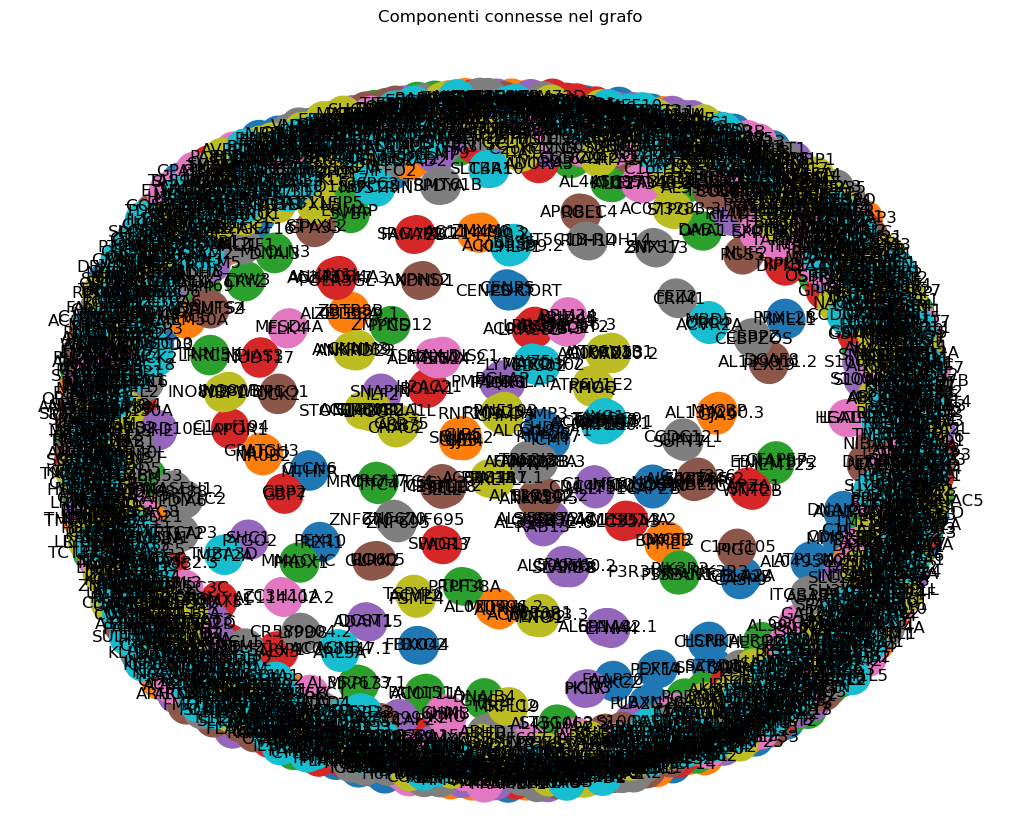

In [30]:
import matplotlib.pyplot as plt

# Assegna un colore a ogni componente connessa
color_map = {}
for i, component in enumerate(connected_components):
    for node in component:
        color_map[node] = i  # Assegna un ID colore per ogni componente

# Colori per i nodi
colors = [color_map[node] for node in G.nodes]

# Disegna il grafo con i colori delle componenti
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(
    G, pos, node_color=colors, with_labels=True, 
    node_size=700, cmap=plt.cm.tab10
)
plt.title("Componenti connesse nel grafo")
plt.show()


In [32]:
from networkx.algorithms.community import greedy_modularity_communities

# Trova comunità usando la modularità
communities = list(greedy_modularity_communities(G))
print("Numero di comunità trovate:", len(communities))

# Mostra le comunità
for i, community in enumerate(communities):
    print(f"Comunità {i + 1}: {sorted(community)}")


Numero di comunità trovate: 1713
Comunità 1: ['AC079447.1', 'AC092587.1', 'C2orf15', 'LIPT1', 'LYG1', 'MITD1', 'MRPL30', 'TSGA10', 'TXNDC9']
Comunità 2: ['AL358472.6', 'AL358472.7', 'CREB3L4', 'JTB', 'RAB13', 'SLC39A1']
Comunità 3: ['AL357556.3', 'ARID4B', 'B3GALNT2', 'GGPS1', 'RBM34', 'TBCE']
Comunità 4: ['AL031847.1', 'CHD5', 'ICMT', 'RNF207', 'RPL22']
Comunità 5: ['GJA4', 'GJB3', 'GJB4', 'GJB5', 'SMIM12']
Comunità 6: ['C1orf112', 'METTL18', 'SCYL3', 'SELE', 'SELL']
Comunità 7: ['AC008073.3', 'FAM228A', 'FAM228B', 'PFN4', 'TP53I3']
Comunità 8: ['AC073082.1', 'GTF2A1L', 'LHCGR', 'STON1', 'STON1-GTF2A1L']
Comunità 9: ['CAPZB', 'MICOS10', 'MICOS10-NBL1', 'NBL1']
Comunità 10: ['P3R3URF', 'P3R3URF-PIK3R3', 'PIK3R3', 'TSPAN1']
Comunità 11: ['AC243547.3', 'ANKRD34A', 'LIX1L', 'POLR3GL']
Comunità 12: ['LYSMD1', 'SCNM1', 'TMOD4', 'TNFAIP8L2']
Comunità 13: ['BGLAP', 'PAQR6', 'PMF1', 'PMF1-BGLAP']
Comunità 14: ['AL590560.2', 'CFAP45', 'SLAMF8', 'VSIG8']
Comunità 15: ['AL512785.2', 'C1orf226', '

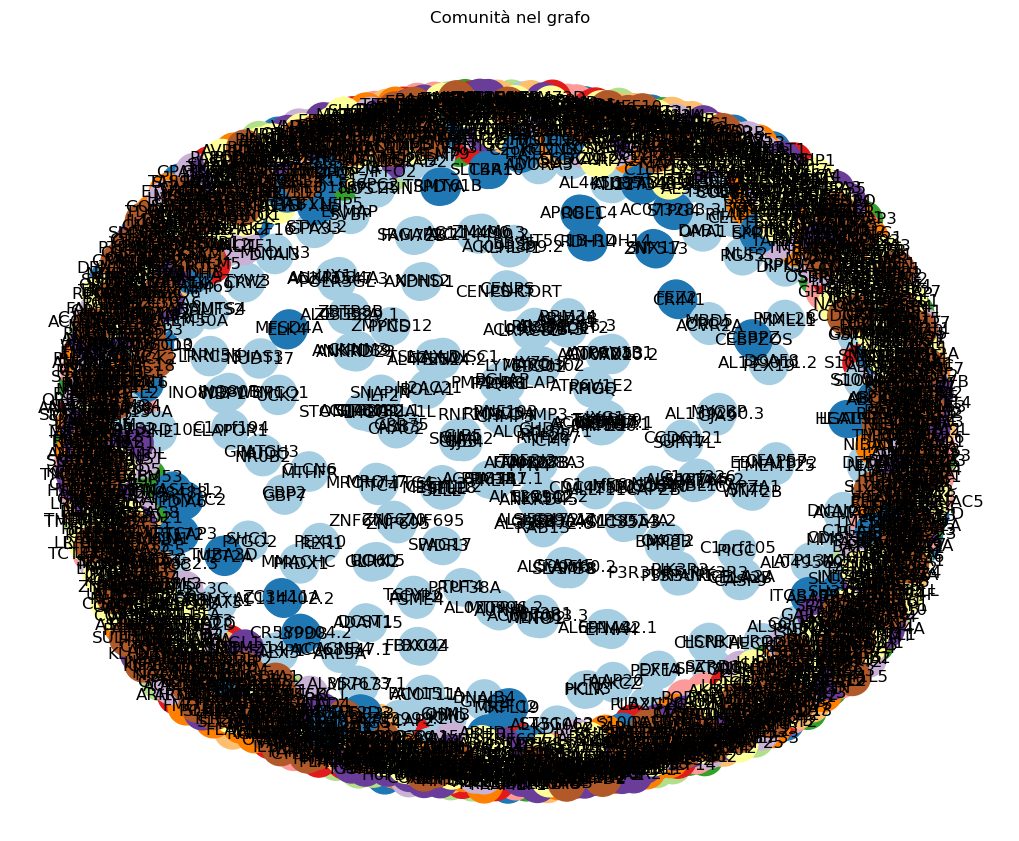

In [33]:
# Assegna un colore a ogni comunità
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Colori per i nodi
community_colors = [community_map[node] for node in G.nodes]

# Disegna il grafo con i colori delle comunità
plt.figure(figsize=(10, 8))
nx.draw(
    G, pos, node_color=community_colors, with_labels=True, 
    node_size=700, cmap=plt.cm.Paired
)
plt.title("Comunità nel grafo")
plt.show()


In [ ]:
# Coefficiente di clustering globale
global_clustering = nx.average_clustering(G)
print("Coefficiente di clustering globale:", global_clustering)

# Coefficiente di clustering per ciascun nodo
clustering_per_node = nx.clustering(G)
print("Clustering per nodo:", clustering_per_node)

#Il coefficiente di clustering misura quanto un nodo è parte di una "triade",
# ovvero se i suoi vicini sono collegati tra loro.

Coefficiente di clustering globale: 0.01710714285714286
Clustering per nodo: {'NOC2L': 0, 'PLEKHN1': 0, 'HES4': 0, 'ISG15': 0, 'RNF223': 0, 'C1orf159': 0, 'TTLL10': 0, 'TNFRSF18': 0, 'B3GALT6': 0, 'C1QTNF12': 0, 'UBE2J2': 0, 'SCNN1D': 0, 'ACAP3': 0, 'CPTP': 0, 'TAS1R3': 0, 'MXRA8': 0, 'MRPL20': 0, 'VWA1': 0, 'ATAD3C': 0, 'ATAD3B': 0, 'ATAD3A': 0, 'SSU72': 0, 'FNDC10': 0, 'MMP23B': 0, 'CDK11B': 0, 'SLC35E2B': 0, 'CDK11A': 0, 'NADK': 0, 'CALML6': 0, 'TMEM52': 0, 'GABRD': 0, 'PRKCZ': 0, 'FAAP20': 0, 'MORN1': 0, 'RER1': 0, 'PEX10': 0, 'PLCH2': 0, 'PANK4': 0, 'HES5': 0, 'PRXL2B': 0, 'MMEL1': 0, 'ACTRT2': 0, 'PRDM16': 0, 'ARHGEF16': 0, 'TPRG1L': 0, 'WRAP73': 0, 'CCDC27': 0, 'SMIM1': 0, 'LRRC47': 0, 'CEP104': 0, 'DFFB': 0, 'AJAP1': 0, 'NPHP4': 0, 'CHD5': 0, 'AL031847.1': 0, 'RPL22': 0, 'RNF207': 0, 'ICMT': 0, 'GPR153': 0, 'HES2': 0, 'TNFRSF25': 0, 'PLEKHG5': 0, 'NOL9': 0, 'TAS1R1': 0, 'ZBTB48': 0, 'PHF13': 0, 'VAMP3': 0, 'UTS2': 0, 'PARK7': 0, 'ERRFI1': 0, 'SLC45A1': 0, 'ENO1': 0, 'CA6': 0, '

In [14]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.data import Data

In [15]:
list_of_Data = []
for case_index in range(0,50):
    df_CNV = list_df_CNV_filled[case_index][:200]
    # Crea un grafo vuoto
    G = nx.Graph()
    # Aggiungi i geni come nodi
    for _, row in df_CNV.iterrows():
        G.add_node(row['gene_name'], x=row['copy_number'])

    # Aggiungi archi basati sulla sovrapposizione delle coordinate (start, end)
    for i, gene1 in df_CNV.iterrows():
        for j, gene2 in df_CNV.iterrows():
            if i >= j:
                continue  # Evita di considerare due volte la stessa coppia
            if gene1['chromosome'] == gene2['chromosome']:
                # Controlla la sovrapposizione dei segmenti
                if (gene1['start'] <= gene2['end']) and (gene1['end'] >= gene2['start']):
                    G.add_edge(gene1['gene_name'], gene2['gene_name'])

    pyg_graph = from_networkx(G)
    if os_list[case_index] > 1000:
        pyg_graph['y'] = torch.tensor([1])
    else:
        pyg_graph['y'] = torch.tensor([0])
    list_of_Data.append(pyg_graph)
    print(case_index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [16]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class simple_GCN(torch.nn.Module):
   def __init__(self, input_feature, hidden_channels, num_classes):
       super(simple_GCN, self).__init__()
       self.conv1 = GCNConv(input_feature, hidden_channels)
       self.conv2 = GCNConv(hidden_channels, hidden_channels)
       self.conv3 = GCNConv(hidden_channels, hidden_channels)
       self.lin = Linear(hidden_channels, num_classes)

   def forward(self, x, edge_index, batch):
       # 1. Obtain node embeddings 
       x = self.conv1(x, edge_index)
       x = x.relu()
       x = self.conv2(x, edge_index)
       x = x.relu()
       x = self.conv3(x, edge_index)

       # 2. Readout layer
       x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

       # 3. Apply a final classifier
       x = F.dropout(x, p=0.5, training=self.training)
       x = self.lin(x)
       
       return x

In [19]:
import torch
from torch_geometric.loader import DataLoader
from collections import OrderedDict
from sklearn.metrics import accuracy_score

#   Model parameter TODO
hyperparameter = {
    'num_classes': 2,
    'epochs': 30,
    'batch_size': 10,
    'seed': 123456,
    'num_workers': 12,
    'lr': 0.01,
    'save_model_period': 10 # How many epoch to wait before save the next model.
}

torch.manual_seed(hyperparameter['seed'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_train_list = list_of_Data[0:35]
data_test_list = list_of_Data[35:50]

train_loader = DataLoader(data_train_list, batch_size=hyperparameter['batch_size'], shuffle=True, num_workers=hyperparameter['num_workers'], pin_memory=True)
test_loader = DataLoader(data_test_list, batch_size=hyperparameter['batch_size'], shuffle=True, num_workers=hyperparameter['num_workers'], pin_memory=True)
# pin_memory=True will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.
# https://pytorch.org/docs/stable/data.html.

node_feature_number = 1
model = simple_GCN(node_feature_number, 10, hyperparameter['num_classes'])
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameter['lr'])
criterion = torch.nn.CrossEntropyLoss()
# Here you could also use a scheduler to validate the model.

def train(loader):
    model.train()
    losses = []
    all_label = []
    all_pred = []
    for data in loader:
        # Get the inputs and labels
        inputs, labels = data.x.unsqueeze(1).to(device), data.y.to(device)
        edge_index, batch = data.edge_index.to(device), data.batch.to(device)
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs, edge_index, batch)
        if isinstance(outputs, list):
            outputs = outputs[0]

        # Compute the loss
        loss = criterion(outputs, labels.squeeze())
        losses.append(loss.item())
        
        # Compute the accuracy
        prediction = torch.max(outputs, 1)[1]
        all_label.extend(labels.squeeze())
        all_pred.extend(prediction)
        score = accuracy_score(labels.squeeze().cpu().data.squeeze().numpy(), prediction.cpu().data.squeeze().numpy())
        # Backward & optimize
        loss.backward()
        optimizer.step()

    # Compute the average loss & accuracy
    training_loss = sum(losses)/len(losses)
    all_label = torch.stack(all_label, dim=0)
    all_pred = torch.stack(all_pred, dim=0)
    training_acc = accuracy_score(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy())

    return training_loss, training_acc
    

def test(loader):
    model.eval()
    losses = []
    all_label = []
    all_pred = []

    with torch.no_grad():
        for data in loader:
            # get the inputs and labels
            inputs, labels = data.x.unsqueeze(1).to(device), data.y.to(device)

            # forward
            outputs = model(inputs, data.edge_index, data.batch)  
            pred = outputs.argmax(dim=1)  # Use the class with highest probability.

            # compute the loss
            loss = criterion(outputs, labels.squeeze())
            losses.append(loss.item())
            # collect labels & prediction
            prediction = torch.max(outputs, 1)[1]
            all_label.extend(labels.squeeze())
            all_pred.extend(prediction)

        # Compute the average loss & accuracy
        test_loss = sum(losses)/len(losses)
        all_label = torch.stack(all_label, dim=0)
        all_pred = torch.stack(all_pred, dim=0)
        test_acc = accuracy_score(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy())

        return test_loss, test_acc
s_epoch=0
for epoch_index in range(s_epoch, hyperparameter['epochs']):
    train_loss, train_acc = train(train_loader)
    # print(train_loss,train_acc)
    test_loss, test_acc = test(test_loader)
    # print(test_loss,test_acc)
    print(f'Epoch: {epoch_index:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    

Epoch: 000, Train Acc: 0.6000, Test Acc: 0.6000
Epoch: 001, Train Acc: 0.5429, Test Acc: 0.6000
Epoch: 002, Train Acc: 0.5429, Test Acc: 0.6000
Epoch: 003, Train Acc: 0.6286, Test Acc: 0.6000
Epoch: 004, Train Acc: 0.4571, Test Acc: 0.6000
Epoch: 005, Train Acc: 0.5429, Test Acc: 0.6000
Epoch: 006, Train Acc: 0.5143, Test Acc: 0.6000
Epoch: 007, Train Acc: 0.5429, Test Acc: 0.6000
Epoch: 008, Train Acc: 0.5714, Test Acc: 0.6000
Epoch: 009, Train Acc: 0.6286, Test Acc: 0.6667
Epoch: 010, Train Acc: 0.6286, Test Acc: 0.7333
Epoch: 011, Train Acc: 0.4286, Test Acc: 0.7333
Epoch: 012, Train Acc: 0.6857, Test Acc: 0.6667
Epoch: 013, Train Acc: 0.5714, Test Acc: 0.6000
Epoch: 014, Train Acc: 0.6571, Test Acc: 0.6667
Epoch: 015, Train Acc: 0.6286, Test Acc: 0.7333
Epoch: 016, Train Acc: 0.6000, Test Acc: 0.8000
Epoch: 017, Train Acc: 0.6286, Test Acc: 0.7333
Epoch: 018, Train Acc: 0.6286, Test Acc: 0.8000
Epoch: 019, Train Acc: 0.6571, Test Acc: 0.7333
Epoch: 020, Train Acc: 0.6286, Test Acc:

In [29]:
t = list_of_Data[0]
print(type(t))

<class 'torch_geometric.data.data.Data'>


In [43]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 10
DataBatch(x=[2000], edge_index=[2, 500], y=[10], batch=[2000], ptr=[11])

Step 2:
Number of graphs in the current batch: 10
DataBatch(x=[2000], edge_index=[2, 500], y=[10], batch=[2000], ptr=[11])

Step 3:
Number of graphs in the current batch: 10
DataBatch(x=[2000], edge_index=[2, 500], y=[10], batch=[2000], ptr=[11])

Step 4:
Number of graphs in the current batch: 5
DataBatch(x=[1000], edge_index=[2, 250], y=[5], batch=[1000], ptr=[6])



In [1]:
for step, data in enumerate(train_loader):
    print(data.x)

NameError: name 'train_loader' is not defined